In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

/home/user/ml/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"].values, mnist["target"].values

In [4]:
y = y.astype(np.uint8)

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [6]:
enc.fit(y[:,np.newaxis])

OneHotEncoder()

In [7]:
Y = enc.transform(y[:,np.newaxis]).toarray()

In [8]:
X_train, X_test, y_train, y_test = X[:30000], X[30000:100000], Y[:30000], Y[30000:100000]

In [9]:
X_train = X_train / 255
X_test = X_test / 255

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [12]:
def compute_cost(X, T, W, lambd):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    #cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1))
    #cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + (lambd / (2 * N)) * np.sum(W ** 2)
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + 1 / (2 * N) * lambd * np.sum(W ** 2)
    return cost

In [13]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [14]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size, lambd):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch))
        #W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch)) + (lambd / batch_size) * W
        cost_history[i] = compute_cost(X_batch, T_batch, W, lambd)
        if i % 1000 == 0:
            print(cost_history[i][0])

    return (cost_history, W)


In [16]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test

iterations = 50000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W, 0)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

best_score = 0
best_lambda = 0

# 시도할 정규화 강도(λ) 값들
lambda_values = np.arange(0, 1, 0.05)

for lam in lambda_values:
    (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, lam)

    y_pred = predict(X_, W_optimal)
    score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))
    #print(f"Lambda: {lam}, Validation Accuracy: {score}")
    
    # 가장 높은 검증 정확도를 가진 λ 업데이트
    if score > best_score:
        best_score = score
        best_lambda = lam

print(f"Best Lambda: {best_lambda}, Best Validation Accuracy: {best_score}")

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, best_lambda)


Initial Cost is: 2.302485097993717 

2.2771580220351635
0.5807060414578233
0.5257428057784597
0.41194056089576836
0.4869103865098985
0.2743658818089968
0.3538596293010983
0.303621944456577
0.2702785839702356
0.20379639447963413
0.20012687372841517
0.34681075999823685
0.388766089095507
0.16948173531697225
0.21628641438545365
0.3215207083653976
0.5099711931453111
0.37630015235087455
0.33010713582242407
0.27209404938287773
0.22756776726758574
0.3351875873520648
0.27842804333785226
0.3072242287115247
0.14717816405045625
0.17575318617656038
0.42584138152485396
0.37720525683893136
0.2877763984300976
0.21542996636590225
0.25609697686949795
0.2954351897699206
0.32234064749332486
0.2801003226508757
0.36473182641873647
0.164844255205074
0.26273035885042584
0.2209070897155572
0.20319949633145634
0.13897480934749262
0.1439176046200825
0.2635031248654921
0.3111139757156246
0.1330270712184366
0.17116910348063238
0.2749377668718469
0.48668677000723337
0.35083333616816376
0.31990849189077747
0.2084356

In [18]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.90048


In [38]:
pip install sympy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 7.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


training score : 0.995 (multinomial)
2.8948750612164673
-0.12278277864625031
5.522634442321161


/tmp/ipykernel_2367/2750627578.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


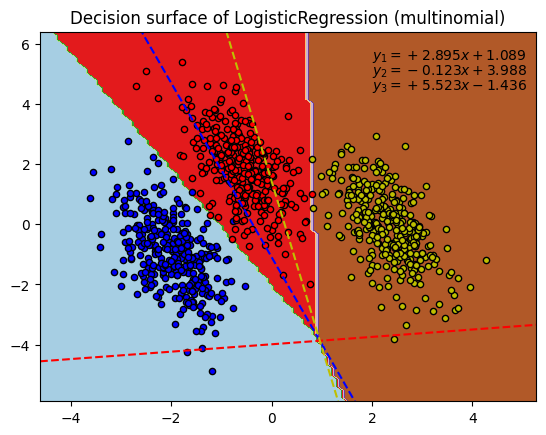

In [76]:
# Authors: Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification 
# 분류를 위한 3개의 클래스 데이터셋 만들기
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

clf = LogisticRegression(
    solver="sag", max_iter=100, random_state=42, multi_class="multinomial"
).fit(X, y)

# print the training scores
# 훈련 점수 출력
print("training score : %.3f (multinomial)" % (clf.score(X, y)))

# 배경 색상 그래프
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", cmap=plt.cm.Paired, ax=ax
)
plt.title("Decision surface of LogisticRegression (multinomial)")
plt.axis("tight")

# Plot also the training points
# 트레이닝 포인트 플롯 (산점도)
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )

# Plot the three one-against-all classifiers
# 3개의 1:1 분류기 플롯 
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

# 세 개의 직선 그래프 부분 
def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)

for i in range(3):
    w = coef[i]
    b = intercept[i]
    print(w[0]/w[1])
    plt.text(2, 5.5-i*0.5, r'$y_{} = {:+.3f}x {:+.3f}$'.format(i+1, w[0]/w[1], b/w[1]), fontdict={'size': 10})
plt.show()


array([[-4.51740321, -1.56048296],
       [-0.08918381,  0.72635442],
       [ 4.60658703,  0.83412854]])